In [1]:
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
from xopt import Xopt
from xopt.evaluator import Evaluator
from xopt.generators import UpperConfidenceBoundGenerator, ExpectedImprovementGenerator
from xopt.generators.bayesian.options import ModelOptions, OptimOptions
from xopt.generators.bayesian.expected_improvement import BayesianOptions
from xopt.generators.bayesian.upper_confidence_bound import UCBOptions
from lume_model.torch import LUMEModule

from utils import NegativeTransverseBeamSize
from utils import load_surrogate, load_corr_model, create_vocs, print_runtime, running_max
from dynamic_custom_mean import DynamicCustomMean, Flatten, OccasionalConstant, OccasionalModel

In [2]:
# define prior mean
mean_class = DynamicCustomMean
mean_kwargs = {}
n_epoch = 10

In [3]:
# BO configuration
acq_name = "EI"  # "EI" or "UCB"
n_init = 3
n_step = 50

In [4]:
# load surrogate model and define objective
surrogate = load_surrogate("configs/lcls_variables.yml", "configs/normalization.json", "torch_model.pt")
objective_name = "negative_sigma_xy"
vocs = create_vocs(surrogate, objective_name)
surrogate_module = LUMEModule(surrogate, vocs.variable_names, ["sigma_x", "sigma_y"])
Objective = NegativeTransverseBeamSize
ground_truth = Objective(surrogate_module)

# Xopt evaluator function
def evaluate(input_dict):
    model_result = surrogate.evaluate(input_dict)
    obj_kwargs = {key:model_result[key] for key in surrogate_module.output_order}
    obj_value = Objective.function(**obj_kwargs).detach().item()
    return {objective_name: obj_value}

In [5]:
# load correlated model
corr_model = load_corr_model(
    "configs/lcls_variables.yml",
    "corr_models/x_transformer.pt",
    "corr_models/y_transformer.pt",
    "corr_models/{:d}ep.pt".format(n_epoch)
)
corr_module = LUMEModule(corr_model, vocs.variable_names, ["sigma_x", "sigma_y"])
mean_kwargs["model"] = Objective(corr_module)

In [6]:
# generate initial data set
inputs_init = pd.DataFrame(vocs.random_inputs(n=n_init, seed=0))
outputs = [evaluate(inputs_init.to_dict(orient="index")[i])[objective_name] for i in range(len(inputs_init))]
outputs_init = pd.DataFrame({objective_name: outputs})
data_init = pd.concat([inputs_init, outputs_init], axis=1)
data_init

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,negative_sigma_xy
0,0.315416,11.849845,0.218563,-0.008702,-0.007148,3.845480,-0.490601,3.625577,-2.844318,1.115676,-4.508010,-4.770960,4.084017,250.0,58000000.0,70000000.0,-2.673201
1,0.421819,4.680301,0.210919,-0.006318,0.009328,-20.211281,-4.794569,1.987560,-2.153845,2.887162,-2.112335,-3.202335,1.662885,250.0,58000000.0,70000000.0,-1.464008
2,0.488126,3.785076,0.222483,0.009938,-0.004593,-8.954229,9.007755,2.057821,-3.982130,3.097626,-0.082182,-1.481926,1.395637,250.0,58000000.0,70000000.0,-2.367977


In [7]:
# run BO
t0 = time.time()

# define dynamic custom mean
mean_kwargs["step"] = 0
model_options = ModelOptions(
    name="trainable_mean_standard",
    mean_modules={objective_name: mean_class(**mean_kwargs)},
)
# Xopt definition
optim_options = OptimOptions(num_restarts=5, raw_samples=20)
if acq_name == "EI":
    generator_options = BayesianOptions(model=model_options, optim=optim_options)
    generator = ExpectedImprovementGenerator(vocs, options=generator_options)
else:
    generator_options = UCBOptions(model=model_options, optim=optim_options)
    generator = UpperConfidenceBoundGenerator(vocs, options=generator_options)
evaluator = Evaluator(function=evaluate)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs, data=data_init)

for i_step in range(n_step):
    # update dynamic custom mean
    mean_kwargs["step"] = i_step
    X.generator.options.model.mean_modules[objective_name] = mean_class(**mean_kwargs)
    # optimization step
    X.step()
    
# print runtime
print_runtime(t0, time.time())

/Users/tboltz/miniconda3/envs/xopt-lume/lib/python3.9/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Runtime: 3.19 min


In [8]:
# print data set
X.data

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,negative_sigma_xy,xopt_runtime,xopt_error
1,0.315416,11.849845,0.218563,-0.008702,-0.007148,3.845480,-0.490601,3.625577,-2.844318,1.115676,-4.508010,-4.770960,4.084017,250.0,58000000.0,70000000.0,-2.673201,NaN,NaN
2,0.421819,4.680301,0.210919,-0.006318,0.009328,-20.211281,-4.794569,1.987560,-2.153845,2.887162,-2.112335,-3.202335,1.662885,250.0,58000000.0,70000000.0,-1.464008,NaN,NaN
3,0.488126,3.785076,0.222483,0.009938,-0.004593,-8.954229,9.007755,2.057821,-3.982130,3.097626,-0.082182,-1.481926,1.395637,250.0,58000000.0,70000000.0,-2.367977,NaN,NaN
4,0.497423,8.180350,0.227247,0.009993,-0.009999,-12.105218,-7.375187,3.734788,-2.756427,2.758166,-2.637769,-2.334568,1.643735,250.0,58000000.0,70000000.0,-0.393665,0.000869,False
5,0.464073,6.965815,0.211819,-0.010000,0.009999,6.804454,-22.818366,3.156490,-1.010512,3.245737,-2.808309,-2.570326,1.296601,250.0,58000000.0,70000000.0,-1.390558,0.000760,False
6,0.499995,5.441041,0.226459,-0.009926,-0.009999,6.145458,-22.046515,3.649462,-3.665942,4.687037,-3.596853,-3.506653,3.781913,250.0,58000000.0,70000000.0,-0.408866,0.000633,False
7,0.348670,3.391660,0.231302,-0.010000,-0.009999,-19.913698,-19.943371,2.950198,-3.032033,4.160295,-3.509804,-2.453279,2.318208,250.0,58000000.0,70000000.0,-0.456692,0.000694,False
8,0.499949,7.394143,0.234450,0.009993,0.009999,-19.275963,-5.146127,3.188977,-3.098587,4.030951,-3.129720,-2.645397,2.638121,250.0,58000000.0,70000000.0,-0.224309,0.000720,False
9,0.498895,5.454485,0.215261,0.009993,-0.009999,-17.967114,-10.557912,3.998198,-1.010512,4.371584,-3.849501,-2.119631,1.305998,250.0,58000000.0,70000000.0,-0.276681,0.000636,False
10,0.500000,9.401127,0.233698,0.009993,0.006793,-2.537961,-9.396743,2.979719,-2.880234,2.231967,-2.054463,-2.221979,2.658960,250.0,58000000.0,70000000.0,-0.350052,0.000680,False


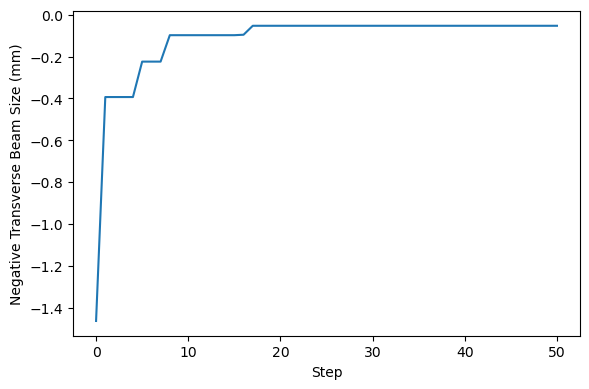

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x = torch.arange(n_step + 1)
y = torch.from_numpy(X.data[objective_name].values)
ax.plot(x, running_max(y.squeeze())[n_init - 1:], "C0-")
ax.set_xlabel("Step")
ax.set_ylabel("{} ({})".format(ground_truth.name, ground_truth.unit))
fig.tight_layout()

In [10]:
x_optimum = X.generator.get_optimum()
y_optimum = pd.DataFrame(evaluate(x_optimum.to_dict("index")[0]), index=[0])
y_optimum

,negative_sigma_xy
0,-0.260256
